Imports

In [1]:
#setting system path
import os, sys
# Get the path to the project root (one level up from /jupyter)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#Python libraries
from langgraph.graph import StateGraph


#Import Project Libraries
from src.llm_chain.chains import (_ambiguity_checker_chain,
                                  _clarifiaction_ques_generation_chain,
                                  _query_consolidator_chain,
                                  _llm_with_context_chain,
                                  _retrieval_required_checker_chain )
from src.schema.state_schema import StateSchema
from src.schema.message_schema import ConversationHistoryMessage


In [2]:
user_input_var = "who is avnoor kaur where the case judgement told that their child can celebrate diwali alternatively each year with father and mother in the judgment of supreme court from the document name that starts with shaina?"

def node_take_user_input(state: StateSchema):

    convo={}
    convo["user"] = "user"
    convo["message"] = state["original_user_query"]
    history = []
    history.append(convo)

    state["conversation_history"] = history
    
    return state

initial_state = StateSchema(original_user_query=user_input_var,
                            clarifications_asked_count=0)

#take_user_input(user_input_var, initial_state)

In [3]:
#Create Node
def node_ambiguity_check(state:StateSchema):

    response = _ambiguity_checker_chain(state["conversation_history"])

    state["clarification_need"] = response["clarification_need"]
    state["ambiguity_reason"] = response["ambiguity_reason"]
    state["ambiguity_score"] = response["ambiguity_score"]

    if state["clarification_need"]:
        state["retrieval_needed"] = False


    return state["clarification_need"]

In [4]:
def node_clarification_ques_gen(state: StateSchema):

    response = _clarifiaction_ques_generation_chain(state["conversation_history"],
                                         state["ambiguity_reason"],
                                         state["clarifications_asked_count"])
    
    state["clarifications_asked_count"] +=1
    new_convo = {"role":"assistant", "message":response}
    state["conversation_history"].append(new_convo)

    return state


In [5]:
def node_retrieval_checker(state: StateSchema):

    response = _retrieval_required_checker_chain(state["conversation_history"])
    state["retrieval_needed"] = response["decision"]

    return response

In [6]:
def generate_llm_response_with_retrieved_context_node(state: StateSchema, contexts):

    return _llm_with_context_chain(state["conversation_history"], contexts)

In [7]:
from langgraph.graph import END, START

#declare agent state graph to use for building node and edges
graph = StateGraph(StateSchema)

#Add nodes in graph
graph.add_node("user_input_node", node_take_user_input)
graph.add_node("ambiguity_checker", _ambiguity_checker_chain)
graph.add_node("clarification_ques_gen", node_clarification_ques_gen)
graph.add_node("retrieval_checker", node_retrieval_checker)

#Add Edges
graph.add_edge(START, "user_input_node")
graph.add_edge("user_input_node", "ambiguity_checker")
graph.add_conditional_edges("ambiguity_checker", node_ambiguity_check, path_map={"Yes":"clarification_ques_gen", "No":"retrieval_checker"})
graph.add_edge("clarification_ques_gen", "user_input_node")
graph.add_edge("retrieval_checker", END)

workflow = graph.compile()


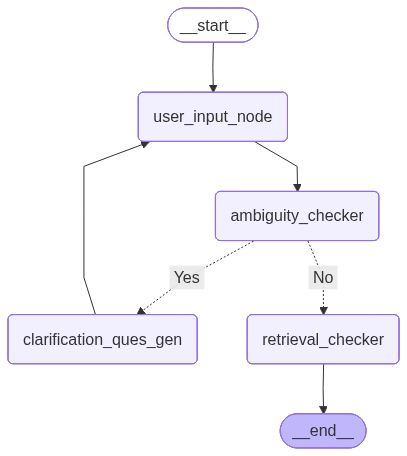

In [8]:


from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

In [11]:
my_query = input("You: ")

my_state = StateSchema(original_user_query= my_query,
                       clarifications_asked_count=0,
                       ambiguity_reason=None,
                       ambiguity_score=0.0,
                       clarification_need=None,
                       consolidated_query=None,
                       conversation_history=None,
                       retrieval_needed=None,
                       stop_reason=None)

#take_user_input(my_query, my_state)

workflow.invoke(my_state)

{'original_user_query': 'hey what is your name',
 'conversation_history': [{'user': 'user',
   'message': 'hey what is your name'}],
 'clarification_need': 'No',
 'ambiguity_reason': 'The user is asking for a personal name, which is a generic, non-legal query, not related to legal research or analysis.',
 'clarifications_asked_count': 0,
 'consolidated_query': None,
 'ambiguity_score': 0.1,
 'stop_reason': None,
 'retrieval_needed': None}